In [1]:
# import zipfile
# with zipfile.ZipFile('potato_plans_diseases.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

In [16]:
#!pip install scikit-learn

In [3]:
#!pip install --upgrade torch torchvision

In [3]:
#!pip install datasets transformers

In [1]:
import torch
from torchvision import  transforms
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from datasets import load_metric
from transformers import ViTForImageClassification
from transformers import TrainingArguments

In [59]:
import sklearn

In [58]:
sklearn.__version__

'1.2.1'

# Data

In [2]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

dataset = load_dataset("imagefolder", data_files={"train": "../dataset/PLD_3_Classes_256/Training/**",\
                                                  "test": "../dataset/PLD_3_Classes_256/Testing/**",\
                                                  "valid": "../dataset/PLD_3_Classes_256/Validation/**"})

In [4]:
train_ds = dataset['train']
val_ds = dataset['valid']
test_ds = dataset['test']

All images in all splits have the same size (256,256) - I checked it.

In [5]:
normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

In [6]:
resize = tuple(feature_extractor.size.values())

In [7]:
_train_transforms = transforms.Compose([transforms.Resize(resize),                          
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(), normalize
                                       ])
_val_transforms = transforms.Compose([transforms.Resize(resize),                          
                                       transforms.ToTensor(), normalize
                                       ])

In [8]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image) for image in examples['image']]
    return examples

In [9]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [10]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [11]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_11383/3314281577.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [12]:
labels = train_ds.features['label'].names
labels = [i.lower() for i in labels]
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
  output_dir="../ml-server/mlmodels/vit-potatoes-plant-health-status/",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  report_to='none',
  push_to_hub=False,
  load_best_model_at_end=True,
)

PyTorch: setting up devices


In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [19]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/srv/conda/envs/saturn/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3251
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 408
  Number of trainable parameters = 85800963


Step,Training Loss,Validation Loss,Accuracy
100,0.040200,0.067163,0.975962
200,0.046000,0.018231,0.997596
300,0.012100,0.023179,0.995192
400,0.005000,0.015188,0.997596


***** Running Evaluation *****
  Num examples = 416
  Batch size = 8
Saving model checkpoint to ./vit-base-potato/checkpoint-100
Configuration saved in ./vit-base-potato/checkpoint-100/config.json
Model weights saved in ./vit-base-potato/checkpoint-100/pytorch_model.bin
Image processor saved in ./vit-base-potato/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 416
  Batch size = 8
Saving model checkpoint to ./vit-base-potato/checkpoint-200
Configuration saved in ./vit-base-potato/checkpoint-200/config.json
Model weights saved in ./vit-base-potato/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-potato/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 416
  Batch size = 8
Saving model checkpoint to ./vit-base-potato/checkpoint-300
Configuration saved in ./vit-base-potato/checkpoint-300/config.json
Model weights saved in ./vit-base-potato/checkpoint-300/pytorch_model.bin
Image processor saved

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 938507602GF
  train_loss               =      0.0489
  train_runtime            =  0:03:38.04
  train_samples_per_second =      59.638
  train_steps_per_second   =       1.871


In [20]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 405
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9951
  eval_loss               =     0.0281
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    139.729
  eval_steps_per_second   =     17.596


# Inference

In [22]:
from PIL import Image

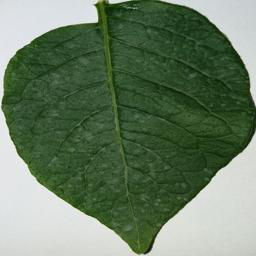

In [23]:
image = Image.open('../ml-server/tests/images/healthy.jpeg')
image

In [24]:
WEIGHTS = "../ml-server/mlmodels/vit-potatoes-plant-health-status/"

In [25]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained(WEIGHTS)

loading configuration file ./Modify/ml-server/mlmodels/vit-potatoes-plant-health-status/preprocessor_config.json
/srv/conda/envs/saturn/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Image processor ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [26]:
inputs = _val_transforms(image)

In [27]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(WEIGHTS)

loading configuration file ./Modify/ml-server/mlmodels/vit-potatoes-plant-health-status/config.json
Model config ViTConfig {
  "_name_or_path": "./Modify/ml-server/mlmodels/vit-potatoes-plant-health-status/",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "early_blight",
    "1": "healthy",
    "2": "late_blight"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "early_blight": "0",
    "healthy": "1",
    "late_blight": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1"
}

loading weights file ./Modify/ml-server/mlmodels/vit-po

In [28]:
with torch.no_grad():
    logits = model(inputs.unsqueeze(0)).logits

Perfect! We got the right result.

In [29]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'healthy'

In [30]:
predicted_label

1

In [97]:
logits

tensor([[-1.6366,  3.8663, -2.0534]])

In [31]:
from transformers import pipeline

In [32]:
clf = pipeline("image-classification", model=WEIGHTS)

loading configuration file ./Modify/ml-server/mlmodels/vit-potatoes-plant-health-status/config.json
Model config ViTConfig {
  "_name_or_path": "./Modify/ml-server/mlmodels/vit-potatoes-plant-health-status/",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "early_blight",
    "1": "healthy",
    "2": "late_blight"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "early_blight": "0",
    "healthy": "1",
    "late_blight": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1"
}

loading configuration file ./Modify/ml-server/mlmodels/

In [33]:
result = clf(image)

In [35]:
result

[{'score': 0.994130551815033, 'label': 'healthy'},
 {'score': 0.002945276675745845, 'label': 'early_blight'},
 {'score': 0.0029240513686090708, 'label': 'late_blight'}]

In [36]:
import glob

In [37]:
images = [Image.open(i) for i in glob.glob('../ml-server/tests/images/*.jpeg')]

In [43]:
results = clf(images)

In [44]:
results

[[{'score': 0.994130551815033, 'label': 'healthy'},
  {'score': 0.002945276675745845, 'label': 'early_blight'},
  {'score': 0.0029240513686090708, 'label': 'late_blight'}],
 [{'score': 0.9954003691673279, 'label': 'late_blight'},
  {'score': 0.00231309630908072, 'label': 'healthy'},
  {'score': 0.0022865948267281055, 'label': 'early_blight'}],
 [{'score': 0.9955145716667175, 'label': 'early_blight'},
  {'score': 0.0026240383740514517, 'label': 'late_blight'},
  {'score': 0.0018613555002957582, 'label': 'healthy'}]]